# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
VAE_TRAIN = False
FIND_DIST = False
FOLDER = "dist5-celeba"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from dataloaders import get_celeba_dataloader

train_loader, test_loader = get_celeba_dataloader(path_to_data='/home/data/bvaa/CelebA')

In [ ]:
# from torchvision import datasets, transforms
# all_transforms = transforms.Compose([
#         transforms.Resize(32),
#         transforms.ToTensor()
#     ])
# train_data = datasets.CIFAR10('/home/data/bvaa/', train=True, download=True,
#                                 transform=all_transforms)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data,target) = next(examples)

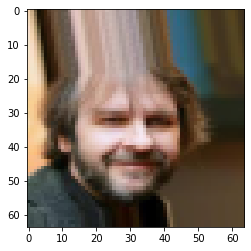

In [5]:
plt.imshow(example_data[3].permute(1,2,0).numpy())

In [6]:
target[3]

tensor(1)

### Define latent distribution of the model

### Build a model

### Train the model

In [7]:
from torch import optim

In [8]:
## Classifiers
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(1024 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         print("x shape:", x.shape)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 36, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model




## Add here

In [9]:
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 64*64
NUM_CLASSES = 2
BATCH_SIZE = 64
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

In [13]:
# torch.manual_seed(RANDOM_SEED)

# ##########################
# ### COST AND OPTIMIZER
# ##########################

# model = resnet152(NUM_CLASSES, GRAYSCALE)
# model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# import time

# from tqdm.notebook import tqdm

# def compute_accuracy(model, data_loader, device):
#     correct_pred, num_examples = 0, 0
#     for i, (features, targets) in enumerate(data_loader):
            
#         features = features.to(device)
#         targets = targets.to(device)

#         logits, probas = model(features)
#         _, predicted_labels = torch.max(probas, 1)
#         num_examples += targets.size(0)
#         correct_pred += (predicted_labels == targets).sum()
#     return correct_pred.float()/num_examples * 100
    

# start_time = time.time()
# for epoch in tqdm(range(NUM_EPOCHS)):
    
#     model.train()
#     for batch_idx, (features, targets) in enumerate(train_loader):
        
#         features = features.to(DEVICE)
#         targets = targets.to(DEVICE)
            
#         ### FORWARD AND BACK PROP
#         logits, probas = model(features)
#         cost = F.cross_entropy(logits, targets)
#         optimizer.zero_grad()
        
#         cost.backward()
        
#         ### UPDATE MODEL PARAMETERS
#         optimizer.step()
        
#         ### LOGGING
#         if not batch_idx % 50:
#             print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
#                    %(epoch+1, NUM_EPOCHS, batch_idx, 
#                      len(train_loader), cost))

        

#     model.eval()
#     with torch.set_grad_enabled(False): # save memory during inference
#         print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
#               epoch+1, NUM_EPOCHS, 
#               compute_accuracy(model, train_loader, device=DEVICE),
#               compute_accuracy(model, test_loader, device=DEVICE)))
        
#     print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
# print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [ ]:
# torch.save(model.state_dict(), './models/celeba/classifier.pt')

In [10]:
classifier = resnet152(NUM_CLASSES, GRAYSCALE)
classifier.to(DEVICE)

classifier.load_state_dict(torch.load('models/celeba/classifier.pt'))
classifier.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 32,
               'disc': [10]}
latent_dim = 42

In [12]:
from celeba.models import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=True).cuda()

In [13]:
from celeba.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 50.0, 100000, 100.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 10.0, 100000, 100.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [ ]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [18]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
    trainer.train(train_loader, epochs=300)
    torch.save(model.state_dict(), 'models/celeba/model.pt')
else:
    model.load_state_dict(torch.load('models/celeba/model.pt'))
    model.eval()

In [15]:
from madry_celeba import WideResNet
classifier2 = WideResNet(depth=22, num_classes=2, widen_factor=10, dropRate=0.0)
classifier2.load_state_dict(torch.load('models/celeba/model_6.pt'))

for param in classifier2.parameters():
    param.requires_grad = False

In [16]:
for param in model.parameters():
    param.requires_grad = False
    
for param in classifier.parameters():
    param.requires_grad = False

In [17]:
from dataloaders import CelebADataset
from torchvision import transforms
train_data = CelebADataset('/home/data/bvaa/CelebA', transform=transforms.ToTensor())

## Digits

In [ ]:
from tqdm.notebook import tqdm
list_index = {}
for i in tqdm(range(len(train_data))):
    index = train_data[i][1]
    if index not in list_index.keys():
        list_index[index] = [i]
    else:
        list_index[index].append(i)

In [22]:
l_sample_list = {}
def get_average_latent_space(list_index):
    for i in tqdm(list_index.keys()):
        for j in list_index[i]:
            output, l_dist = model(train_data[j][0].unsqueeze(0).cuda())
            l_sample_x = model.reparameterize(l_dist)
            if i not in l_sample_list.keys():
                l_sample_list[i] = [l_sample_x]
            else:
                l_sample_list[i].append(l_sample_x)
        l_sample_list[i] = {'mean':torch.mean(torch.stack(l_sample_list[i]), dim=0),
                           'std':torch.std(torch.stack(l_sample_list[i]), dim=0)}
        
get_average_latent_space(list_index)

In [23]:
def added_noise(image, digit, alphax=0.2, betay=1, plot=False):
    output, l_dist = model(image.unsqueeze(0).float().cuda())
    l_sample_x = model.reparameterize(l_dist)
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=-1, max=1)
    test_sample = l_sample_list[digit]['mean'] + alpha*l_sample_list[digit]['std']
    test_sample = betay * l_sample_x + alphax * test_sample
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(test[0].permute(1, 2, 0).cpu().detach().numpy(), interpolation='none')
    return test_sample

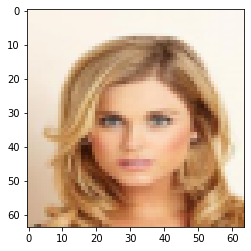

In [97]:
plt.imshow(example_data[30].permute(1,2,0).numpy())

tensor([[-2.6250e-02, -1.4935e-02, -7.6977e-03, -2.4351e-01, -6.5740e-02,
          3.5333e-02, -6.9334e-01, -2.5679e-01, -1.5295e-01, -2.4421e-01,
         -4.6563e-03,  7.2876e-02,  9.2254e-02,  1.9178e+00, -1.7049e-02,
          5.6049e-02,  1.0722e-02,  2.4075e-02,  3.6201e-01,  1.4101e-02,
          3.6742e-02, -5.7471e-02, -2.9431e-02,  2.1400e-01, -1.4927e-02,
          7.3849e-02, -1.4549e-03, -5.7894e-01,  8.4942e-03, -6.4708e-02,
         -6.7079e-01, -1.8810e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.2000e+00,  0.0000e+00]], device='cuda:0')

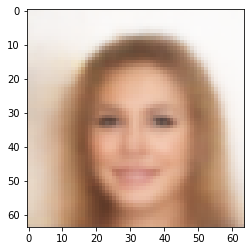

In [96]:
added_noise(example_data[30], 0, plot=True)

In [26]:
import math
def check_distribution(digit, plot=False):
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=-1, max=1)
    test_sample = l_sample_list[digit]['mean'] + alpha*l_sample_list[digit]['std']
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(test[0].permute(1, 2, 0).cpu().detach().numpy(), interpolation='none')
    return test_sample

tensor([[ 1.2205e-02, -3.2749e-02,  2.6537e-01,  1.5153e-01,  4.9772e-02,
          5.3371e-02, -4.0809e-01,  6.4983e-01, -3.9216e-01, -4.0884e-02,
          2.4214e-02,  5.2069e-02,  3.2622e-02,  1.0873e+00,  3.0415e-02,
         -1.3964e-02,  3.0973e-02, -5.2449e-04, -6.7398e-01,  1.3210e-02,
         -4.0896e-01, -8.5892e-02,  1.7175e-02,  5.1842e-01, -3.2414e-02,
          2.2152e-02, -6.2421e-03, -5.7394e-01,  3.1872e-02, -2.3162e-02,
         -3.7941e-01, -3.0353e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00]], device='cuda:0')

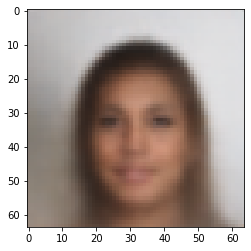

In [27]:
check_distribution(1, plot=True)

In [28]:
def digits_add(digit1, digit2, alpha=1, beta=1, plot=False):
    l_1 = check_distribution(digit1)
    l_2 = check_distribution(digit2)
    if plot:
        test = model.decode(beta*l_1+alpha*l_2)
        plt.imshow(test[0].permute(1,2,0).cpu().detach().numpy(), interpolation='none')
#         preds = classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True))
#         print(preds.dtype)
#         print(torch.argmax(preds).item())
    return torch.norm(l_1-l_2), l_1, l_2

In [29]:
def get_avg_dist(digit1, digit2, exp=10000):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    distance = []
    similarity = []
    for i in range(exp):
        dist, l1, l2 = digits_add(digit1,digit2)
        similar = cos(l1,l2)
        distance.append(dist.item())
        similarity.append(similar.item())
    a = round(sum(distance)/len(distance),5)
    b = round(sum(similarity)/len(similarity),5)
    return a,b

In [30]:
def digit_to_study(digit):
    distance = {}
    similarity = {}
    for i in tqdm(range(10)):
        distance[i], similarity[i] = get_avg_dist(digit,i)
    return distance, similarity

In [ ]:
# get_avg_dist(1,3)

In [ ]:
# get_avg_dist(1,2)

In [ ]:
# get_avg_dist(2,3)

In [31]:
# digits_add(1,-1,0,plot=True)

In [ ]:
# digits_add(1,3,0.3,True)

In [ ]:
# digits_add(1,2,True)

In [ ]:
# digit_to_study(1)

In [ ]:
# digit_to_study(2)

In [ ]:
# check_distribution(2)

In [ ]:
# if FIND_DIST is True:
#     l_means = []
#     l_stds = []
#     for i in l_sample_list.keys():
#         l_means.append(l_sample_list[i]['mean'])
#         l_stds.append(l_sample_list[i]['std'])

#     l_mean_tensor = torch.stack(l_means).squeeze(1)
#     # print(l_mean_tensor.shape)

#     l_std_tensor = torch.stack(l_stds).squeeze(1)
#     # print(l_std_tensor.shape)

#     torch.save(l_mean_tensor, 'tensor/latent_mean.pt')
#     torch.save(l_std_tensor, 'tensor/latent_std.pt')

# else:
#     l_mean_tensor = torch.load('tensor/latent_mean.pt')
#     l_std_tensor = torch.load('tensor/latent_std.pt')

### Visualize

In [ ]:
# examples = enumerate(test_loader)
# batch_idx, (example_data,target) = next(examples)

In [ ]:
# def check(i, digit1, digit2):
    
#     alpha = torch.clamp(torch.randn(l_sample_list[digit1]['std'].shape).cuda(), min=-1, max=1)
#     test_sample = l_sample_list[digit1]['mean'] + F.normalize(alpha)*l_sample_list[digit1]['std']
    
#     alpha = torch.clamp(torch.randn(l_sample_list[digit2]['std'].shape).cuda(), min=-1, max=1)
#     test_sample += l_sample_list[digit2]['mean'] + F.normalize(alpha)*l_sample_list[digit2]['std']
    
#     example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
#     output, l_dist = model(example_img)
#     l_sample = model.reparameterize(l_dist)
#     test_sample = l_sample + 0.4*test_sample
#     test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds)
#     plt.imshow(model.decode(test_sample)[0,0].cpu().detach().numpy(), cmap='gray', interpolation='none')

In [ ]:
# check(2,1,7)

In [ ]:
# def plot_64(data):
#     l_sample = None
#     for i in range(data.shape[0]):
#         output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
#         l_sample_x = model.reparameterize(l_dist_x)
#         if l_sample is None:
#             l_sample = l_sample_x
#         else:
#             l_sample += l_sample_x
#     l_sample = l_sample / data.shape[0]
#     new_output = model.decode(l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
#     print(pred)
#     print(torch.argmax(pred))
#     return l_sample

In [ ]:
# def get_batch_avg(data):
#     l_sample = None
#     for i in range(data.shape[0]):
#         output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
#         l_sample_x = model.reparameterize(l_dist_x)
#         if l_sample is None:
#             l_sample = l_sample_x
#         else:
#             l_sample += l_sample_x
#     l_sample = l_sample / data.shape[0]
# #     new_output = model.decode(l_sample)
# #     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# #     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
# #     print(pred)
# #     print(torch.argmax(pred))
#     return l_sample

In [ ]:
# def plot_avg_mnist(img1, data):
# #     new_l_sample = None
# #     count = len(list_to_process)
#     output, l_dist_x = model(img1.cuda())
#     l_sample_x = model.reparameterize(l_dist_x)
#     l_sample_y = get_batch_avg(data)
# #     output, l_dist_y = model(img2.cuda())
# #     l_sample_y = model.reparameterize(l_dist_y)
    
#     l_sample = 1*l_sample_x + 0.4*l_sample_y
    
#     new_output = model.decode(l_sample)
# #     for i in list_to_process:
# #         example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
# #         output, l_dist = model(example_img)
# #         l_sample = model.reparameterize(l_dist)
# #         if new_l_sample is None:
# #             new_l_sample = l_sample
# #         else:
# #             new_l_sample += l_sample
# #     new_l_sample = new_l_sample / count
# #     new_output = model.decode(new_l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
#     print(pred)
#     print(torch.argmax(pred))
#     print(pred[0,2].item(), pred[0,5].item())

In [ ]:
# def plot_mnist(list_to_process):
#     new_l_sample = None
#     count = len(list_to_process)
#     for i in list_to_process:
#         example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
#         output, l_dist = model(example_img)
#         l_sample = model.reparameterize(l_dist)
#         if new_l_sample is None:
#             new_l_sample = l_sample
#         else:
#             new_l_sample += l_sample
#     new_l_sample = new_l_sample / count
#     new_output = model.decode(new_l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [ ]:
# def check(i, j, alpha, beta):
#     im1 = example_data[i,:,:,:].unsqueeze(0).cuda()
#     im2 = example_data[j,:,:,:].unsqueeze(0).cuda()
#     out1, l_dist1 = model(im1)
#     out2, l_dist2 = model(im2)
#     l_sample1 = model.reparameterize(l_dist1)
#     l_sample2 = model.reparameterize(l_dist2)
#     l_sample = alpha*l_sample1 + beta*l_sample2
#     new_out = model.decode(l_sample)
# #     new_out1 = model.decode(l_sample1)
# #     new_out2 = model.decode(l_sample2)
#     plt.figure(figsize=(10,15))
#     plt.subplot(1,3,1)
#     plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     plt.subplot(1,3,2)
#     plt.imshow(example_data[j][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     plt.subplot(1,3,3)
#     plt.imshow(new_out[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     print(torch.argmax(classifier(F.upsample(new_out, (28,28), mode='bilinear', align_corners=True))))

In [ ]:
# alpha=1
# beta = 1.2
# check(19,11, alpha, beta)

In [ ]:
# class Attack(nn.Module):
#     def __init__(self, attack_digit=attack_digit, target_digit=target_digit, vae=model, classifier=classifier, avg_latent=l_sample_list):
#         super(self, Attack).__init__()
#         self.classifier = classifier
#         self.classifier.eval()
#         self.vae = vae
#         self.vae.eval()
#         self.avg_latent = avg_latent
#         self.attack_digit = attack_digit
#         self.target_digit = target_digit
#         self.hidden_layers = hidden_layers
#         self.hidden_layers.insert(0, latent_dim)
#         self.hidden_layers.append(latent_dim)
#         self.layers = []
        
#         for i in range(len(self.hidden_layers)-1):
#             self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
#         self.layers = nn.ModuleList(self.layers)
        
#     def forward(self, x, y):
#         _, l_dist_x = self.vae(x)
#         _, l_dist_y = self.vae(y)
#         l_sample_x = self.vae.reparameterize(l_dist_x)
#         l_sample_y = self.vae.reparameterize(l_dist_y)
#         noised_sample = l_sample
#         for layer in self.layers:
#             noised_sample = layer(noised_sample)
#         noised_images = self.vae.decoder(noised_sample)
#         preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))
#         return x

In [32]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [33]:
use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

# Constrained Translator
class Noise(nn.Module):
    def __init__(self, hidden_layers=[50, 100, latent_dim], latent_dim=latent_dim):
        super(Noise, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [34]:
# Constrained Cofficients
class Cofficients(nn.Module):
    def __init__(self, hidden_layers=[40, 20, 10, 1], latent_dim=latent_dim):
        super(Cofficients, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# import torch
# use_cuda = True
# device = torch.device('cuda' if use_cuda else 'cpu')


# def create_logits(preds, device=device):
#     preds = preds.cpu()
#     logits = preds.cpu()
    
#     sorted_ = torch.argsort(preds, dim=1, descending=True)
#     first = sorted_[:,0]
#     second = sorted_[:,1]
#     print(first)
#     print(second)
    
#     p_first = preds.gather(1, first.view(-1,1))
#     p_second = preds.gather(1, second.view(-1,1))
#     means = torch.mean(torch.stack([p_first, p_second]), dim=0).squeeze(1)
#     print(means)
#     diff = 0.1*(first - second)
#     print(diff)
#     print((means-diff).shape)
#     j = torch.arange(logits.size(0)).long()
#     logits[j, first] = torch.FloatTensor(means - diff)
#     logits[j, second] = torch.FloatTensor(means + diff)
# #     print(logits[0])
#     return logits.to(device), first, second

# a = torch.randn((10,4)).cuda()
# b = create_logits(a)

In [38]:
# from skimage.metrics import structural_similarity as ssim

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')


def create_logits(preds, device=device):
    preds = preds.cpu()
    logits = preds
    
    sorted_ = torch.argsort(preds, dim=1, descending=True)
    first = sorted_[:,0]
    second = sorted_[:,1]
    
    p_first = preds.gather(1, first.view(-1,1))
    p_second = preds.gather(1, second.view(-1,1))
#     print(p_first.shape)
    
    means = torch.mean(torch.stack([p_first, p_second]), dim=0).squeeze(1)
#     print(means.shape)
    diff = 0.5*(p_first - p_second).squeeze(1)
#     print(diff.shape)
    j = torch.arange(logits.size(0)).long()
    
    logits[j, first] = torch.FloatTensor(means - diff)
    logits[j, second] = torch.FloatTensor(means + diff)
    
    return logits.to(device), first, second

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, decoder=model.decode, classifier=classifier,
                 latent_dim=latent_dim, l_samples=l_sample_list,
                 classes=len(l_sample_list.keys())):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
#         self.means = means
#         self.stds = stds
        self.l_samples = l_samples
        self.classes = classes
        self.latent_dim = latent_dim
        
        
    def forward(self, coffs, noises, org_x, targets, alpha=0.6, beta=1):
        
        org_image = self.decoder(org_x)
        
        preds = self.classifier(org_image)[1]
#         print(preds)
        
        alt_target, first, second = create_logits(preds)
        
        means = []
        stds = []
        
        for key in second:
            means.append(self.l_samples[key.item()]['mean'])
            stds.append(self.l_samples[key.item()]['std'])
        
        means = torch.stack(means)
        stds = torch.stack(stds)
        noised_latent = means.squeeze(1) + torch.clamp(noises, min=-2, max=2) * stds.squeeze(1)
        
        noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#         noise_latent = F.normalize(coffs) * noise_latent
        
        noised_sample = beta * org_x + alpha * noised_latent
        
        noised_image = self.decoder(noised_sample)
#         print(noised_image.shape)
        preds = self.classifier(noised_image)[1]
        
        loss1 = ssim_loss(org_image, noised_image)
#         print(preds.shape)
#         print(alt_target.shape)
        loss2 = nn.BCELoss(reduction='sum')(preds, alt_target)
        
        loss3 = torch.norm(org_image-noised_image, p=2)  

        loss = 400*(1-loss1) + 0.6*loss2 + 20*loss3
#         loss = 0.8*loss2 + 20*loss3
#         loss = loss2 + 20*loss3
#         loss.requires_grad = True
        
        out_labels = preds.argmax(dim=1, keepdim=True)
#         print(out_labels)
#         print(torch.empty(out_labels.shape).fill_(target_label))
#         print(preds)
#         correct = out_labels.eq(torch.Tensor([target_label]*out_labels.shape[0]).to(device)).sum()
#         print(out_labels.shape)
#         print((out_labels.squeeze(1)==targets.cuda()).sum())
        correct = (out_labels.squeeze(1)==targets.cuda()).sum()
#         print(out_labels.shape)
#         print(correct)
#         print(torch.Tensor([target_label]*out_labels.shape[0]))
#         print(out_labels)
        return loss, correct.item()

In [39]:
# alt_target = 5
noise = Noise().to(device)
cofficient = Cofficients().to(device)

for param in noise.parameters():
    param.requires_grad=True
    
for param in cofficient.parameters():
    param.requires_grad=True

tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
# count_digit = 0
# for i in range(len(train_data)):
#     if train_data[i][1]==5:
#         count_digit += 1
# print(count_digit)

In [40]:
from tqdm.notebook import tqdm
attack_log_interval = 1

noise.train()
cofficient.train()

optimizer1 = optim.Adam(noise.parameters(), lr=1e-4)
# optimizer1 = torch.optim.SGD(noise.parameters(), lr=1e-4, momentum=0.9)

# optimizer2 = torch.optim.SGD(cofficient.parameters(), lr=1e-4, momentum=0.9)
optimizer2 = optim.Adam(cofficient.parameters(), lr=1e-4)


# scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=1e-7, max_lr=0.1)
# scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer2, base_lr=1e-7, max_lr=0.1)

for epoch in tqdm(range(150)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.float()
        data = torch.Tensor(data).float().to(device)
#         print(data.type)
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        n = noise(l_sample)
        c = cofficient(l_sample)

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        loss, correct = tloss(c, n, l_sample, target, alpha=1, beta=0)

        loss.backward()
        
        optimizer1.step()
        optimizer2.step()

#         scheduler1.step()
#         scheduler2.step()

        epoch_loss += loss.item()
    
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

Train Epoch: 1	Loss: 3571.243283	Correct: 68106
Train Epoch: 2	Loss: 869.882183	Correct: 67192
Train Epoch: 3	Loss: 623.605519	Correct: 65740
Train Epoch: 4	Loss: 620.467566	Correct: 65734
Train Epoch: 5	Loss: 619.459099	Correct: 65736
Train Epoch: 6	Loss: 618.857825	Correct: 65739
Train Epoch: 7	Loss: 619.051315	Correct: 65735
Train Epoch: 8	Loss: 618.098259	Correct: 65739
Train Epoch: 9	Loss: 617.897646	Correct: 65739
Train Epoch: 10	Loss: 617.246098	Correct: 65740
Train Epoch: 11	Loss: 617.545489	Correct: 65735
Train Epoch: 12	Loss: 617.781839	Correct: 65737
Train Epoch: 13	Loss: 617.558696	Correct: 65735
Train Epoch: 14	Loss: 617.193429	Correct: 65743
Train Epoch: 15	Loss: 617.141896	Correct: 65742
Train Epoch: 16	Loss: 617.732538	Correct: 65742
Train Epoch: 17	Loss: 617.232201	Correct: 65745
Train Epoch: 18	Loss: 617.610722	Correct: 65741
Train Epoch: 19	Loss: 617.821811	Correct: 65738
Train Epoch: 20	Loss: 617.119474	Correct: 65738
Train Epoch: 21	Loss: 617.405732	Correct: 65743


KeyboardInterrupt: 

In [41]:
torch.save(noise, 'models/{}/noise.pt'.format(FOLDER))
torch.save(cofficient, 'models/{}/coff.pt'.format(FOLDER))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Noise. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Cofficients. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
noise.eval()
cofficient.eval()
total_correct = 0
total_test = 0
for batch_idx, (data, target) in enumerate(test_loader):
    total_test += data.shape[0]
    data = data.float()
    data = torch.Tensor(data).float().to(device)

    _, l_dist = model(data)
    l_sample = model.reparameterize(l_dist)
    
    noise_ = noise(l_sample)
    coff_ = cofficient(l_sample)
    
    loss, correct = tloss(coff_, noise_, l_sample, target, 0., 0)
    total_correct += correct
#     print(correct)
#         loss.backward()
#         optimizer.step()
#         print(correct)
#         epoch_loss += loss.item()
    

#     if (epoch+1) % attack_log_interval == 0:
#         print('Train Epoch: \tCorrect: {}'.format(
#             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

16422
Accuracy:  54.74


In [68]:
def check(i, alpha=0.6, beta=1):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)

    _,org_preds = classifier(model.decode(l_sample))
#     print("original: ", torch.argmax(org_preds, dim=1))

    noises = noise(l_sample)
    coffs = cofficient(l_sample)

    d = torch.argsort(org_preds, dim=1, descending=True)
#     print(d)

    noised_latent = l_sample_list[d[0,1].item()]['mean'].squeeze(1) + torch.clamp(noises, min=-5, max=5) * l_sample_list[d[0,1].item()]['std'].squeeze(1)
    
    noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#     noised_latent = F.normalize(coffs) * noised_latent

    noised_sample = beta * l_sample + alpha * noised_latent

    noised_image = model.decode(noised_sample)

    _,fake_preds = classifier(noised_image)
#     print("noised: ", torch.argmax(fake_preds, dim=1))
#     print(example_data[i].permute(1,2,0).shape)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i].permute(1,2,0).detach().cpu().numpy())
    plt.title("org:{}".format(torch.argmax(org_preds, dim=1)))
    plt.subplot(1,2,2)
    plt.imshow(noised_image[0].permute(1,2,0).detach().cpu().numpy())
    plt.title("fake:{}".format(torch.argmax(fake_preds, dim=1)))

In [51]:
examples = enumerate(test_loader)

In [52]:
batch_idx, (example_data,target) = next(examples)

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


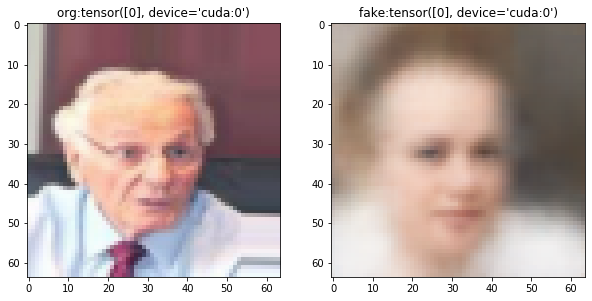

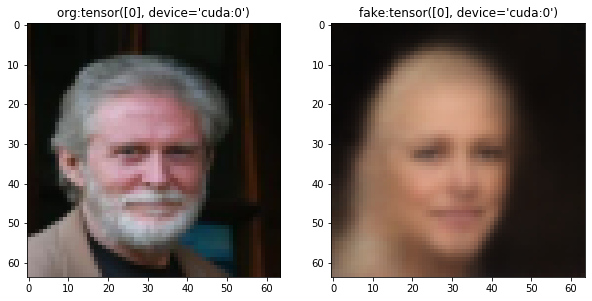

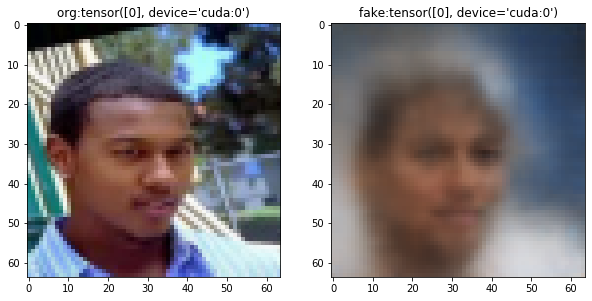

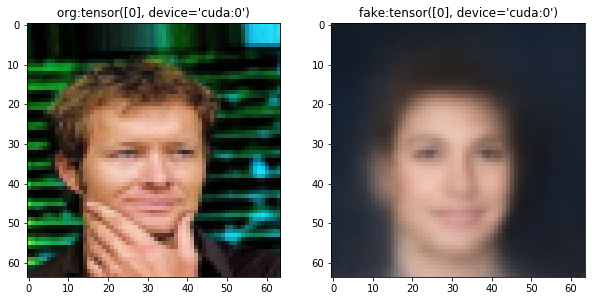

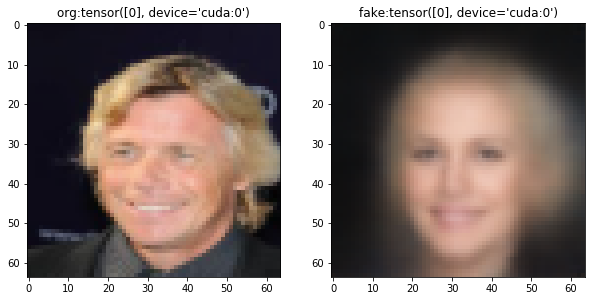

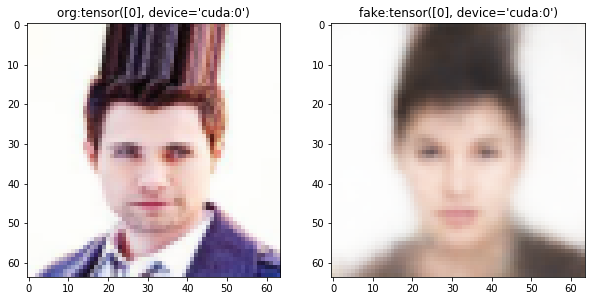

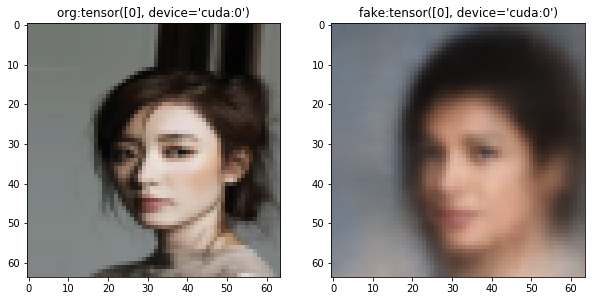

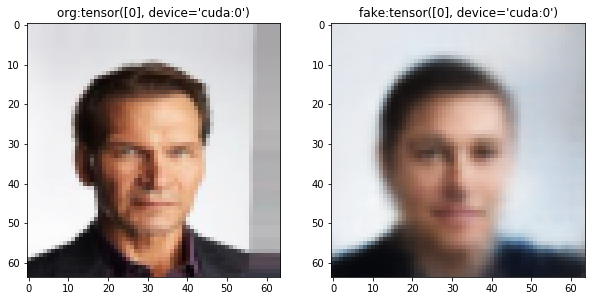

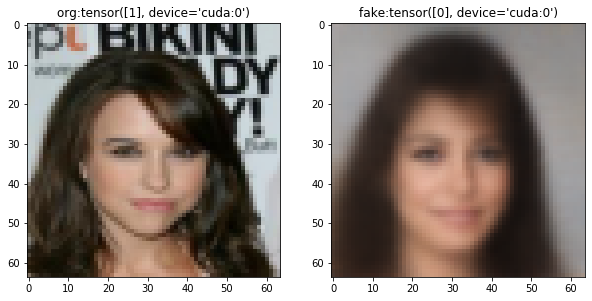

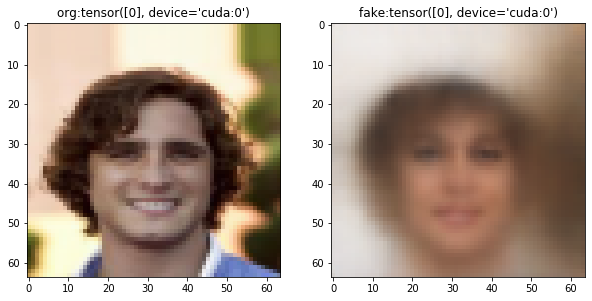

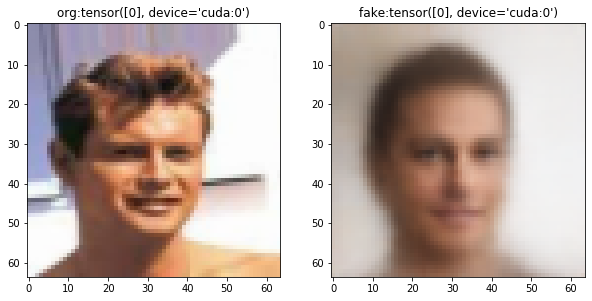

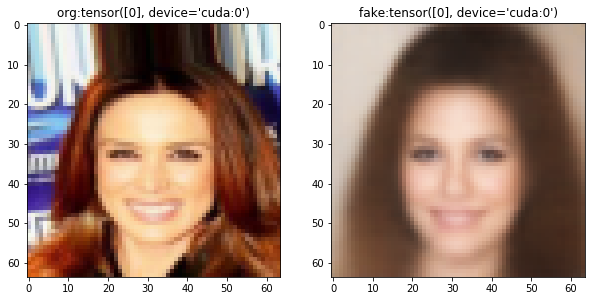

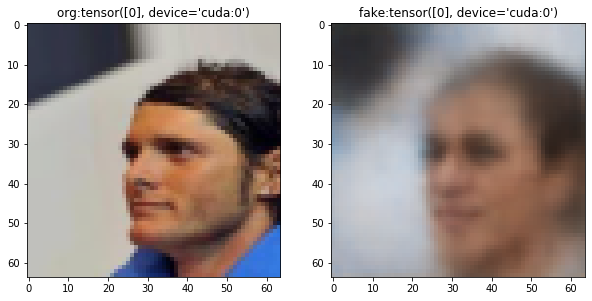

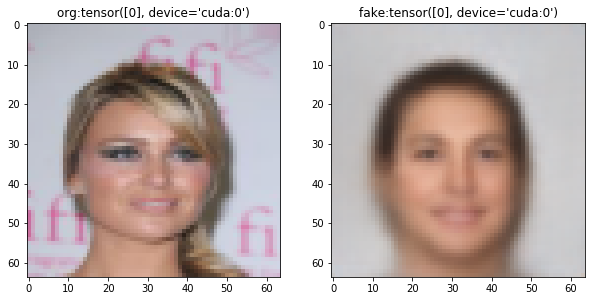

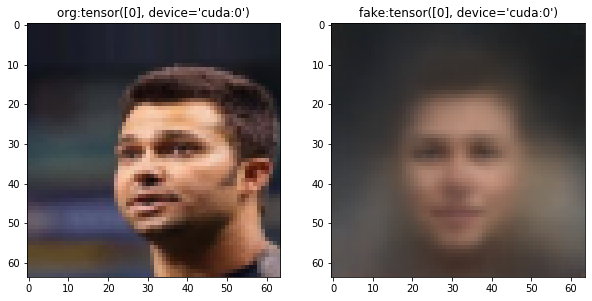

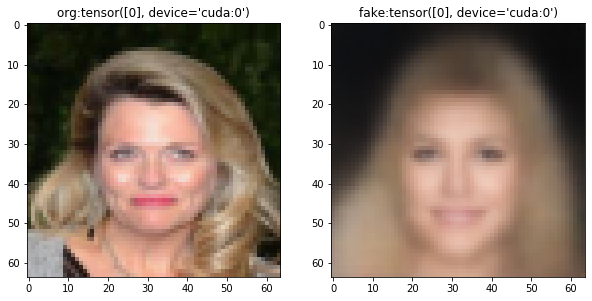

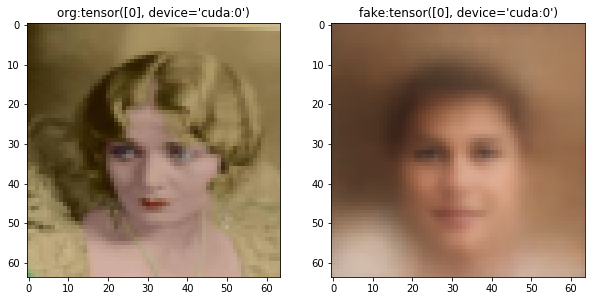

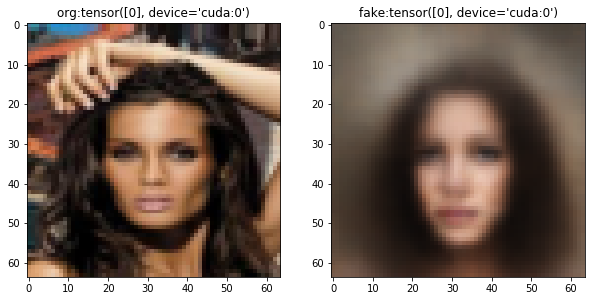

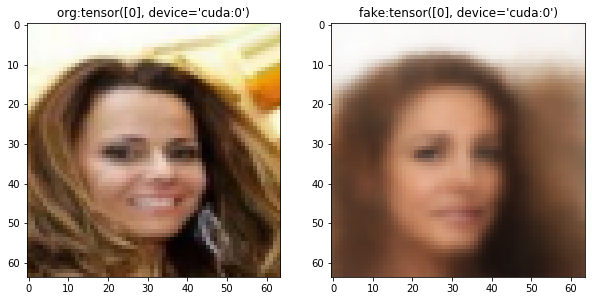

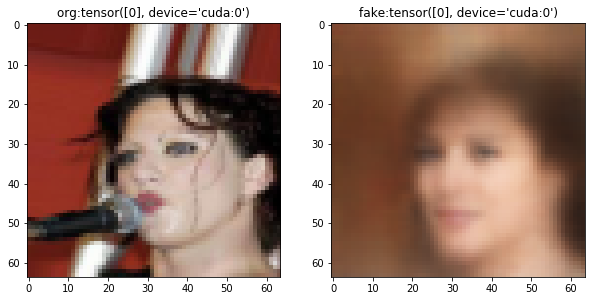

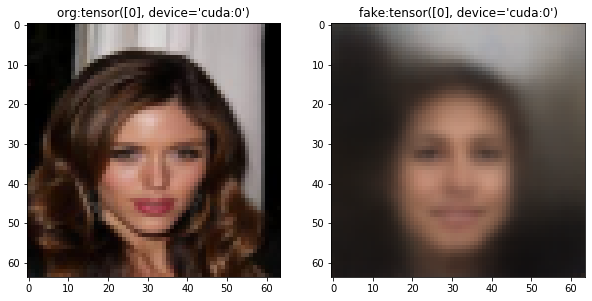

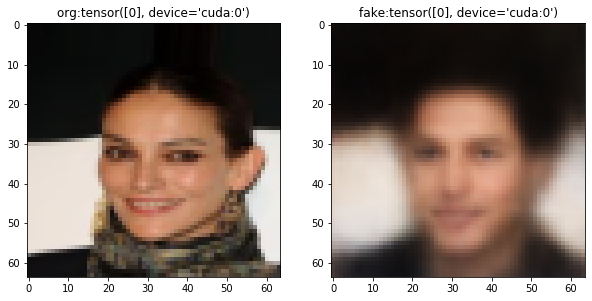

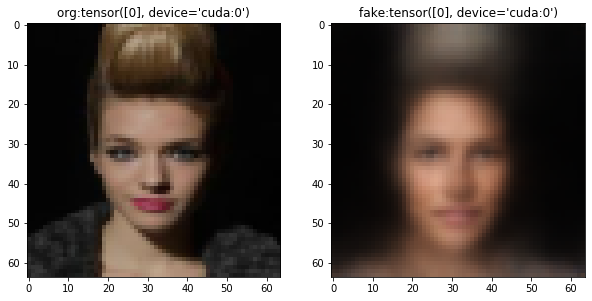

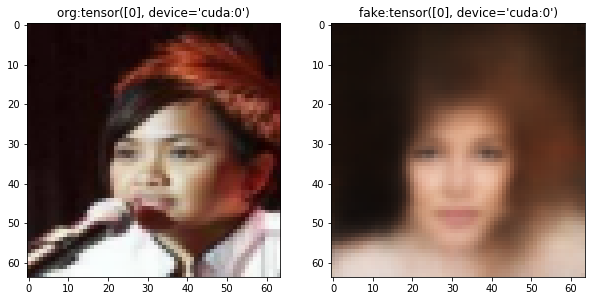

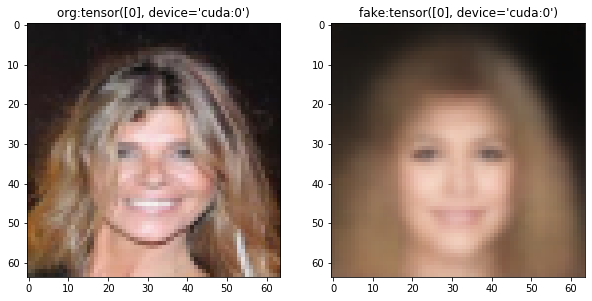

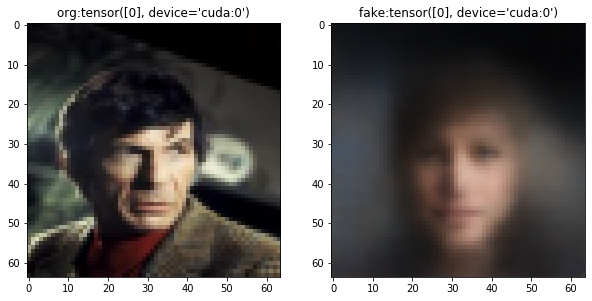

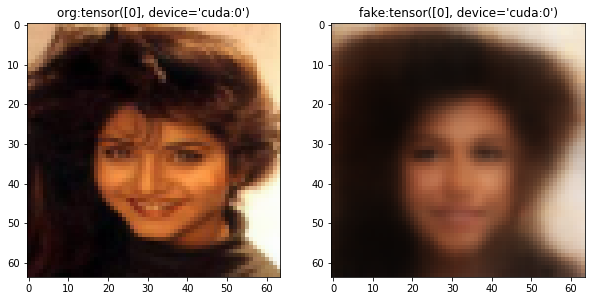

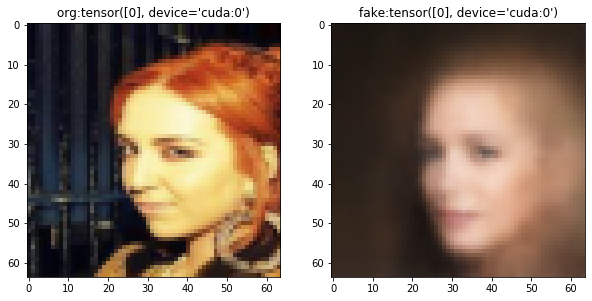

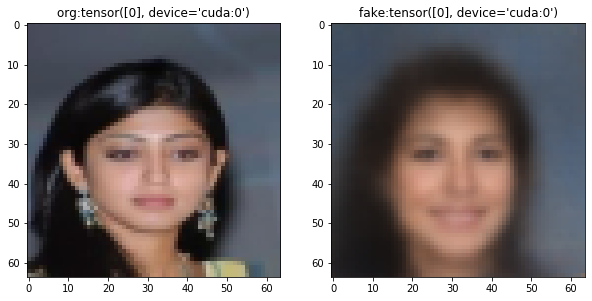

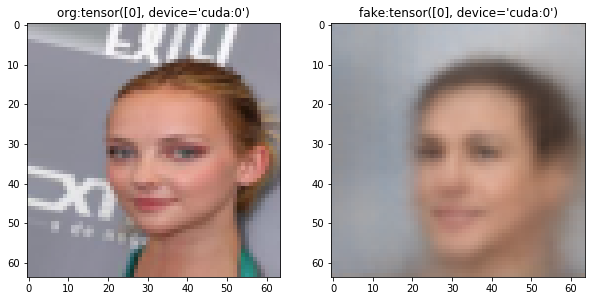

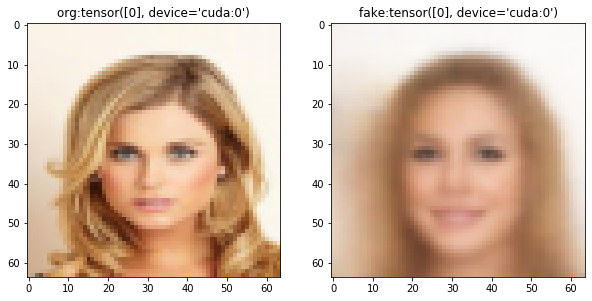

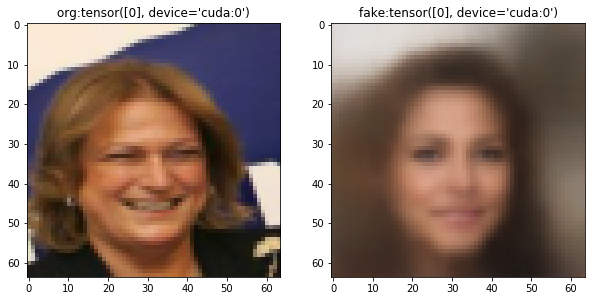

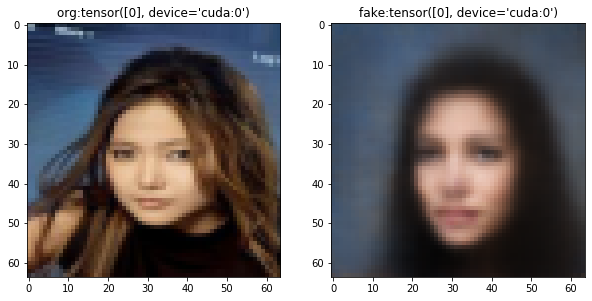

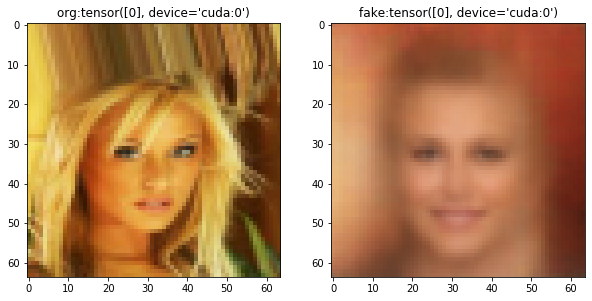

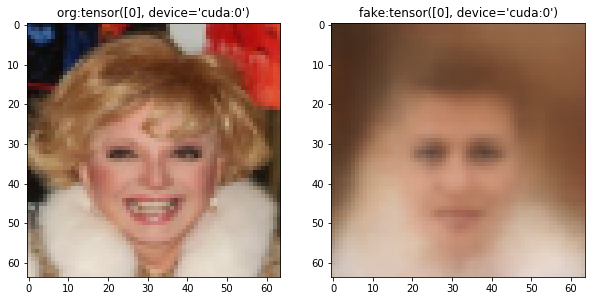

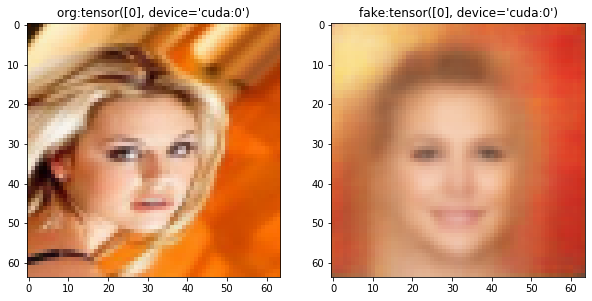

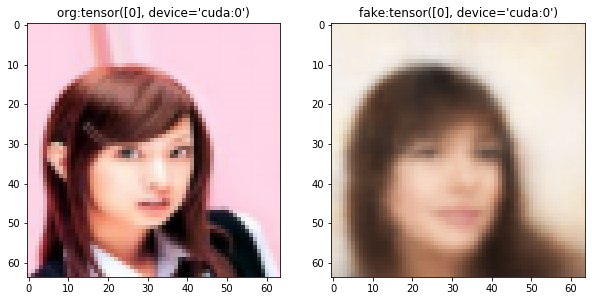

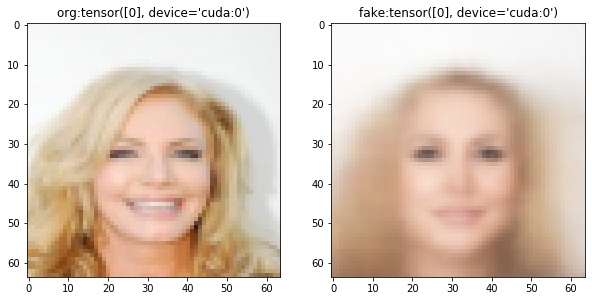

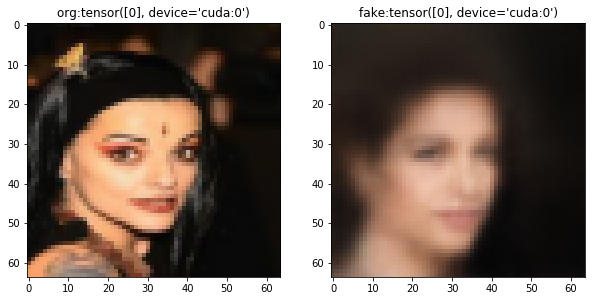

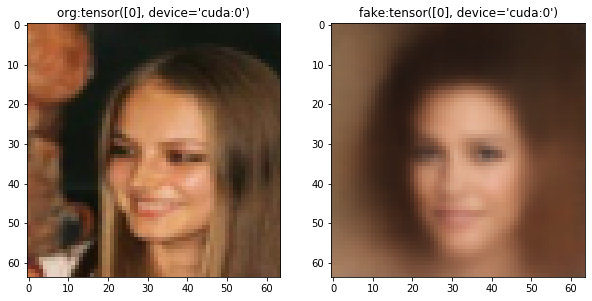

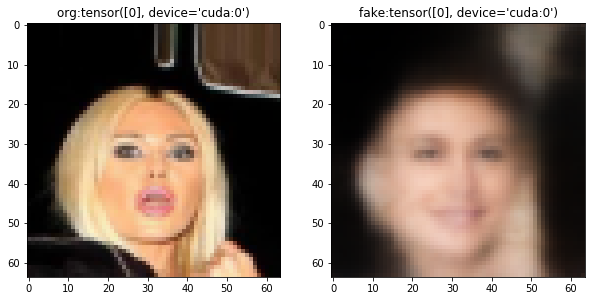

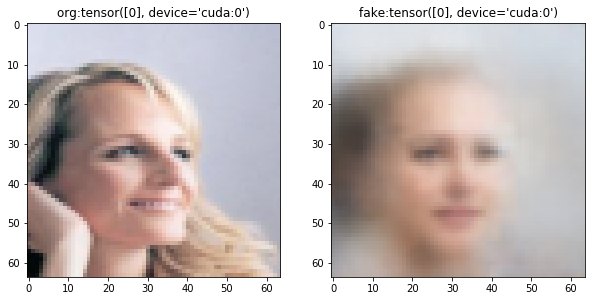

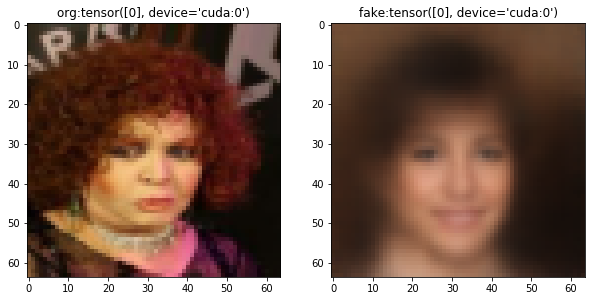

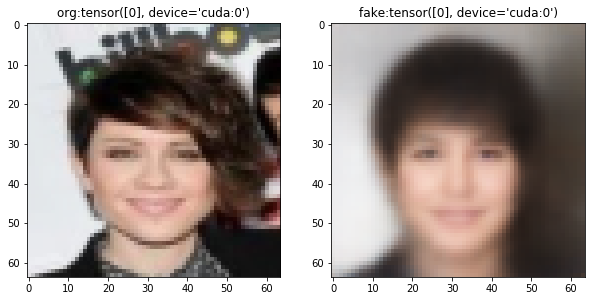

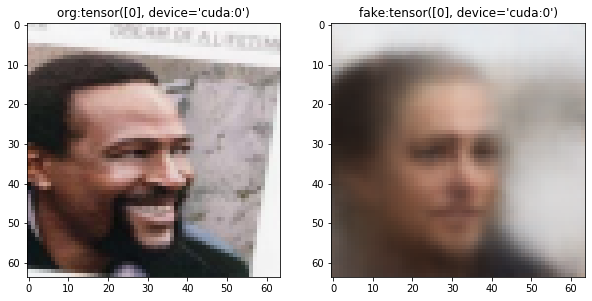

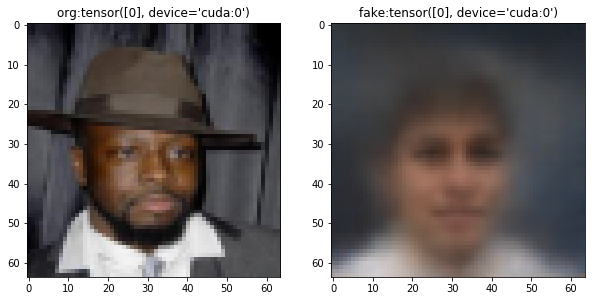

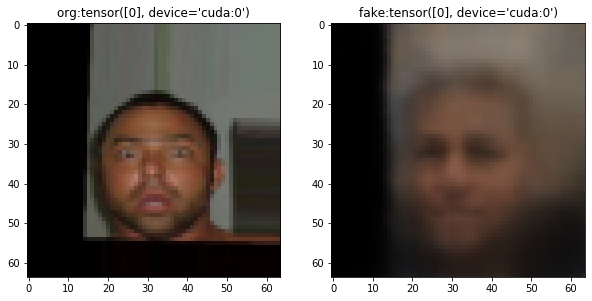

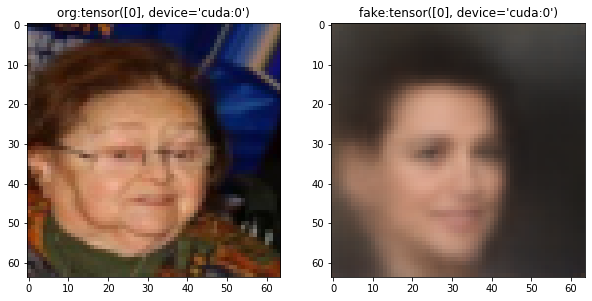

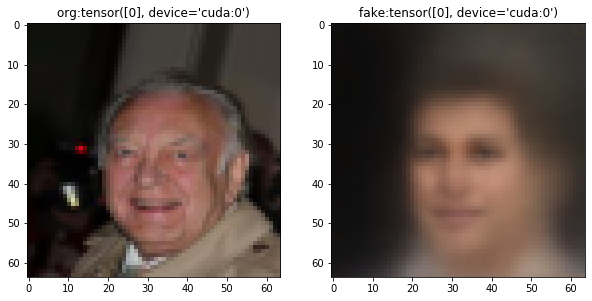

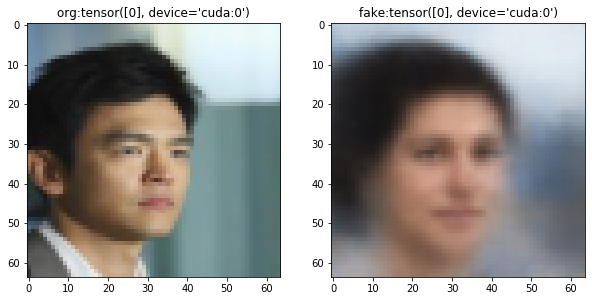

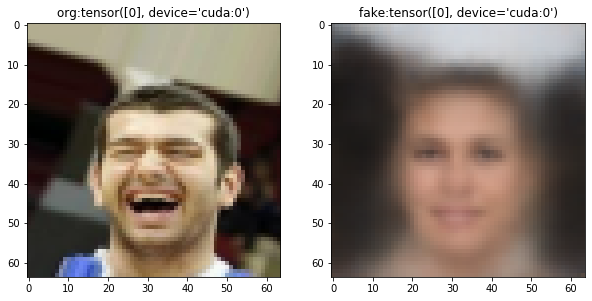

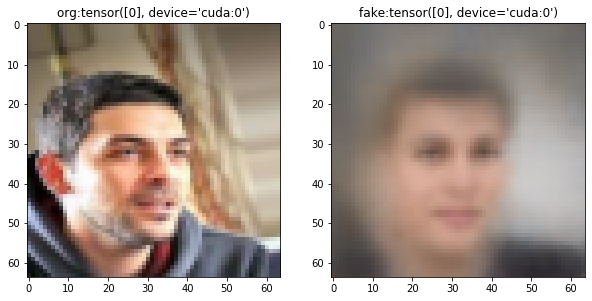

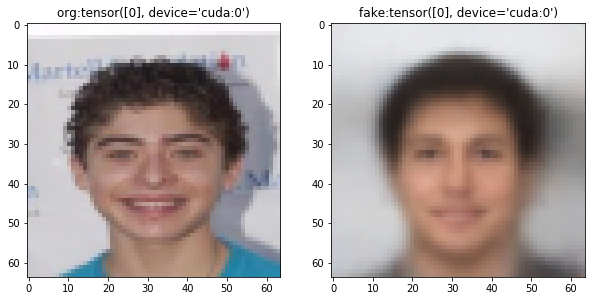

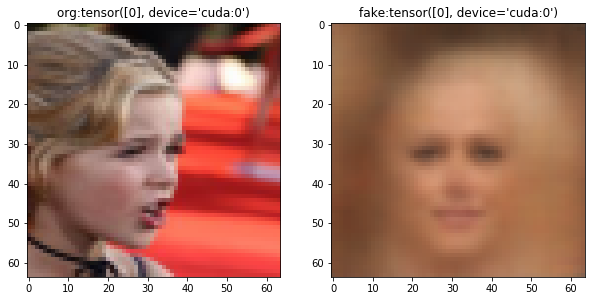

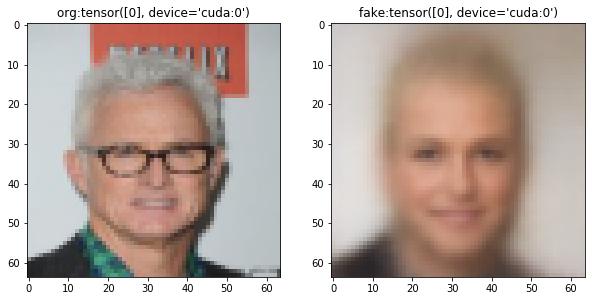

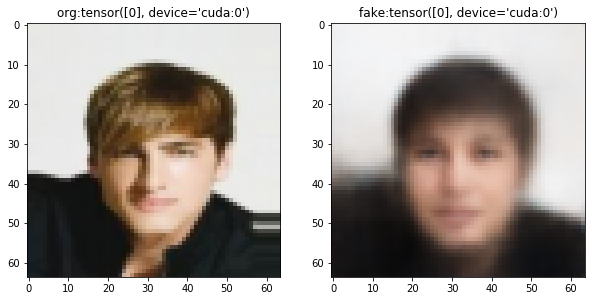

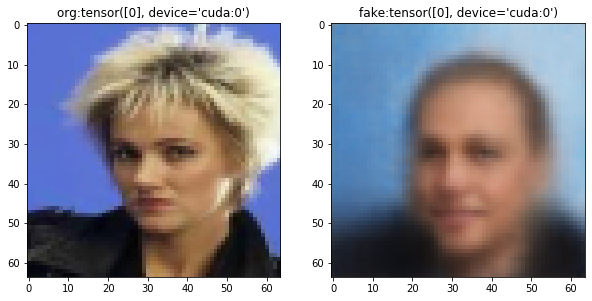

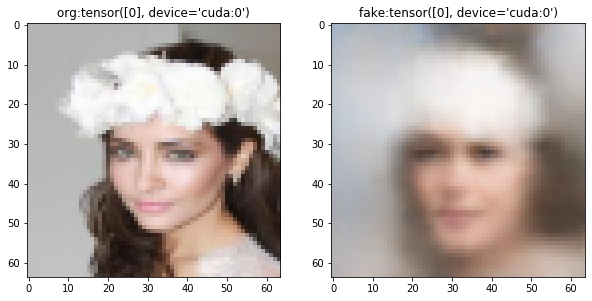

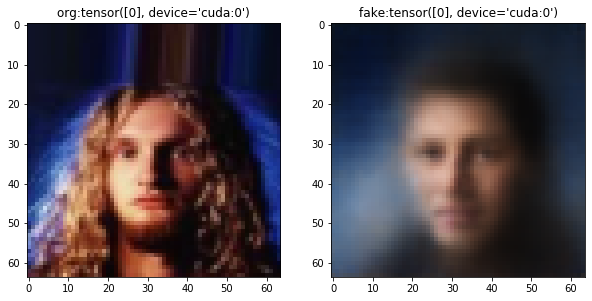

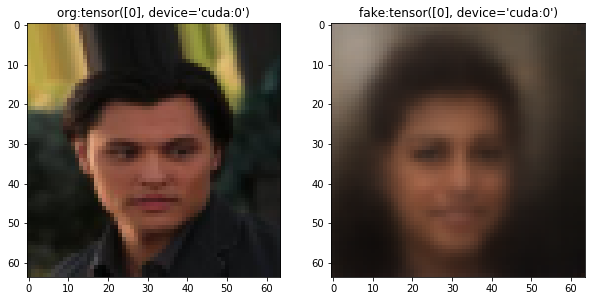

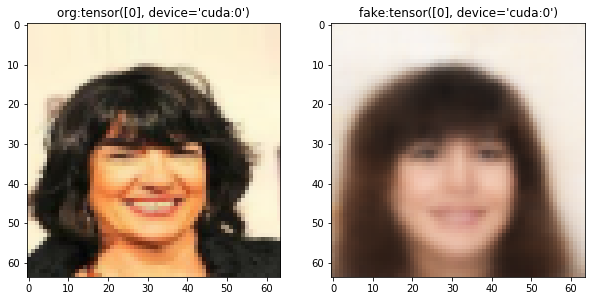

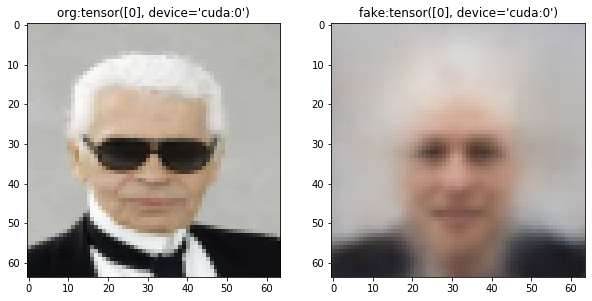

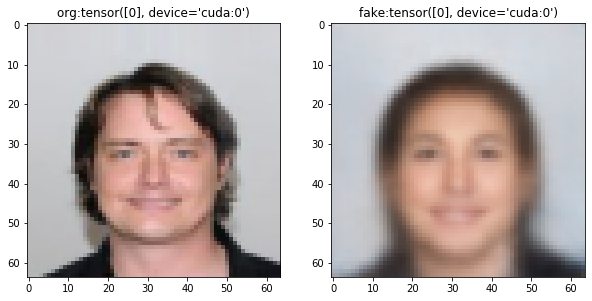

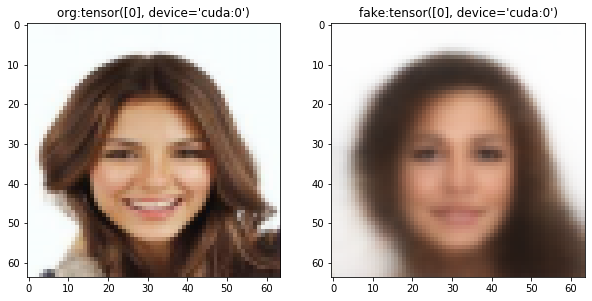

In [69]:
for i in range(64):
    check(i,1,0)

In [ ]:
def test(i, means=l_mean_tensor, stds=l_std_tensor, latent_dim=latent_dim, classes=len(train_data.classes)):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    noises = noise(l_sample)
    coffs = cofficient(l_sample)
#     print(coffs.shape)
#     print(noises.shape)
    noised_latent = means + noises.reshape(noises.shape[0], classes, latent_dim)*stds
    noised_latent = coffs[:,:,None]*noised_latent
#     print(noised_latent.shape)
#     print(l_sample.shape)
#     print(torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1).shape)
#     noised_latent = l_sample + 2e-1*torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1)
#     print(noised_latent.shape)
#     print(noised_sample)
#     print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
#     noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(l_sample+1e-12*noised_latent.sum(dim=1))
#     print(final.shape)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)), dim=1)
#     print(pred)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}, {}".format(pred_org.item(), pred.item()))

In [ ]:
for i in range(64):
    test(i)

In [ ]:
torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.8, max=0.3)*self.avg_latent.T, 1, 2).sum(1)